In [0]:
import pandas as pds
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, FastText
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score

import numpy as np
import tensorflow as tf
from tensorflow import keras
from gensim.models import FastText
import seaborn as sns

path = "/content/drive/My Drive/Colab Notebooks/"

Import fastText model

In [0]:
ft_model = FastText.load(path + "fasttext_5-gram.model")

Generator Class,
To not overload RAM, read `batch_size` lines at the time and feed to LSTM

In [0]:
class BatchGenerator(object):
  
    def __init__(self, file_path, labels, num_sent, num_lang, batch_size, max_words, vec_size, ft_model):
        self.file_path = file_path
        self.batch_size = batch_size
        self.labels = labels
        
        # number of words allowed
        self.max_words = max_words

        # track the progress of the batches sequentially through the data set
        self.current_idx = 0
        self.batch_ctr = 0

        # size of fasttext representation"
        self.vec_size = vec_size
        
        self.num_sent = num_sent
        self.num_lang = num_lang
        self.ft_model = ft_model
      
    def gram_matrix(self, line):
        out_mat = np.zeros((self.max_words, self.vec_size))
      
        tri_grams = line.split("&")
        for i in range(self.max_words):
            try:
                out_mat[i, :] = ft_model.wv[tri_grams[i]]
            except: # FastText throws error if no word sub-n-gram is found
                out_mat[i, :] = np.zeros(self.vec_size)
        
        return out_mat
    
    def generate_gram(self):
        x = np.zeros((self.batch_size, self.max_words, self.vec_size))
        y = np.zeros((self.batch_size, self.num_lang))

        while True:

            with open(self.file_path, "r", encoding="utf8") as f:
                for line in f:
                    if self.batch_ctr >= self.batch_size:
                        self.batch_ctr = 0
                        yield x,y
                                      
                    if not self.current_idx < self.num_sent:
                        self.current_idx = 0
                        break
                        
                    #print("Num words:", len(line.split(" ")))
                    assert self.current_idx != self.num_sent
                    
                    x[self.batch_ctr, :, :] = self.gram_matrix(line)
                    y[self.batch_ctr, :] = keras.utils.to_categorical(self.labels[self.current_idx], num_classes=self.num_lang)

                    self.current_idx += 1
                    self.batch_ctr += 1
                    
            yield x,y

Import dataset labels

In [0]:
train_cat = [int(cat) for cat in read_file(path + "y_train_id.txt")[0]]
valid_cat = [int(cat) for cat in read_file(path + "y_valid_id.txt")[0]]
test_cat = [int(cat) for cat in read_file(path + "y_test_id.txt")[0]]

In [0]:
# The number of n-gram sequences to each row in the original dataset
test_lens = pds.read_pickle(path + "x_test_lens.pkl")

# The labels to the original test set
real_test_cat = pds.read_pickle(path + "y_test_original.pkl")

Setup Keras model

In [0]:
batch_size = 1024
max_words = 10 # Number of n-grams in sequence
vec_size = 100 # Size of fastText vector
train_generator = BatchGenerator(path + "x_train_data.txt", train_cat, len(train_cat), 235, batch_size, max_words, vec_size, ft_model)
valid_generator = BatchGenerator(path + "x_valid_data.txt", valid_cat, len(valid_cat), 235, batch_size, max_words, vec_size, ft_model)
test_generator = BatchGenerator(path + "x_test_data.txt", test_cat, len(test_cat), 235, batch_size, max_words, vec_size, ft_model)

In [0]:
use_dropout = True
hidden_size = 200

model = keras.Sequential()
model.add(keras.layers.CuDNNLSTM(hidden_size, 
                                 return_sequences=True, 
                                 #activity_regularizer=keras.regularizers.l2(0.01),
                                 #recurrent_regularizer=keras.regularizers.l1(0.02),
                                 input_shape=(max_words, vec_size)))
if use_dropout:
    model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(235, activation = 'softmax'))


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 10, 200)           241600    
_________________________________________________________________
dropout (Dropout)            (None, 10, 200)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 235)               470235    
Total params: 711,835
Trainable params: 711,835
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath=path + 'model-{epoch:02d}.hdf5', verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)

In [0]:
num_epochs = 5
train_steps = int(np.ceil(int(len(train_cat)//(batch_size))))
valid_steps = int(np.ceil(int(len(valid_cat)//(batch_size))))

model.fit_generator(train_generator.generate_gram(), train_steps, 
                    validation_data=valid_generator.generate_gram(), validation_steps=valid_steps,
                    epochs=num_epochs, initial_epoch=0,
                    workers=8, verbose = 1, use_multiprocessing=False, callbacks=[checkpointer, early_stopping])

Epoch 1/5
1294/7375 [====>.........................] - ETA: 47:05 - loss: 3.0320 - categorical_accuracy: 0.2947

In [0]:
# Load previously trained model if possible
model = keras.models.load_model(path + "model-01.hdf5")

Make predictions

In [0]:
test_steps = int(np.ceil(int(len(test_cat)//(batch_size))))

preds = model.predict_generator(test_generator.generate_gram(), steps=test_steps, workers=8, use_multiprocessing=False, verbose=1)

3719/3719 [==============================] - 1732s 466ms/step


In [0]:
cat_id = pds.read_pickle(path +"id_to_lang.pkl")
id_dict = cat_id.to_dict('index')
truth = [id_dict[re]['label'] for re in real_test_cat]

Count the # of sequences for each row in the original test set, sum the predictions for each n-gram sequence and make a final prediction

In [0]:
i = 0

out_arr = []
max_l = len(preds)
for lens in test_lens:
    prediction = np.zeros(235)
    for j in range(i,i + lens):
        if j >= max_l:
            break
        prediction = prediction + preds[j]

    out_arr.append(id_dict[np.argmax(prediction)]['label'])
    i += lens
    
predictions = np.array(out_arr)

In [0]:
y_len = len(out_arr)
print(y_len)
answers = np.array(out_arr)[:y_len]
# Should print 117500

117500


In [0]:
print("Accuracy       : ", sum(truth == predictions) / len(predictions)*100)
print("Macro Precision: ", precision_score(truth, predictions, average="macro")*100)
print("Micro Precision: ", precision_score(truth, predictions, average="micro")*100)
print("Recall         : ", recall_score(truth, predictions, average="macro")* 100)
print("F1             : ", f1_score(truth, predictions, average="macro")* 100)

Accuracy       :  63.8663829787234


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro Precision:  69.26693087196458
Micro Precision:  63.8663829787234
Recall         :  63.866382978723415
F1             :  59.33926298479564


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Also evaluate each individual n-gram sequence

In [0]:
all_grams_prediction = []
for r in preds:
    all_grams_prediction.append(id_dict[np.argmax(r)]['label'])
    
all_y_len = len(all_grams_prediction)
print(all_y_len)
all_grams_predictions = np.array(all_grams_prediction)

3808256


In [0]:
all_grams_truth = pds.read_pickle(path + "y_test_labels.pkl")

In [0]:
def get_cat(id):
    return cat_id[cat_id.cat == id].label.values

In [0]:
print("Accuracy       : ", sum(all_grams_truth == all_grams_predictions) / len(all_grams_predictions)*100)
print("Macro Precision: ", precision_score(all_grams_truth, all_grams_predictions, average="macro")*100)
print("Micro Precision: ", precision_score(all_grams_truth, all_grams_predictions, average="micro")*100)
print("Recall         : ", recall_score(all_grams_truth, all_grams_predictions, average="macro")* 100)
print("F1             : ", f1_score(all_grams_truth, all_grams_predictions, average="macro")* 100)

Accuracy       :  41.767964128461955


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro Precision:  43.257284459595205
Micro Precision:  41.767964128461955
Recall         :  38.711591449046715
F1             :  36.7541911717842


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So the "ensembled" predictions from each sequence contribute to a better prediction!

In [0]:
conf_mat = confusion_matrix(truth, answers, cat_id.label.values)

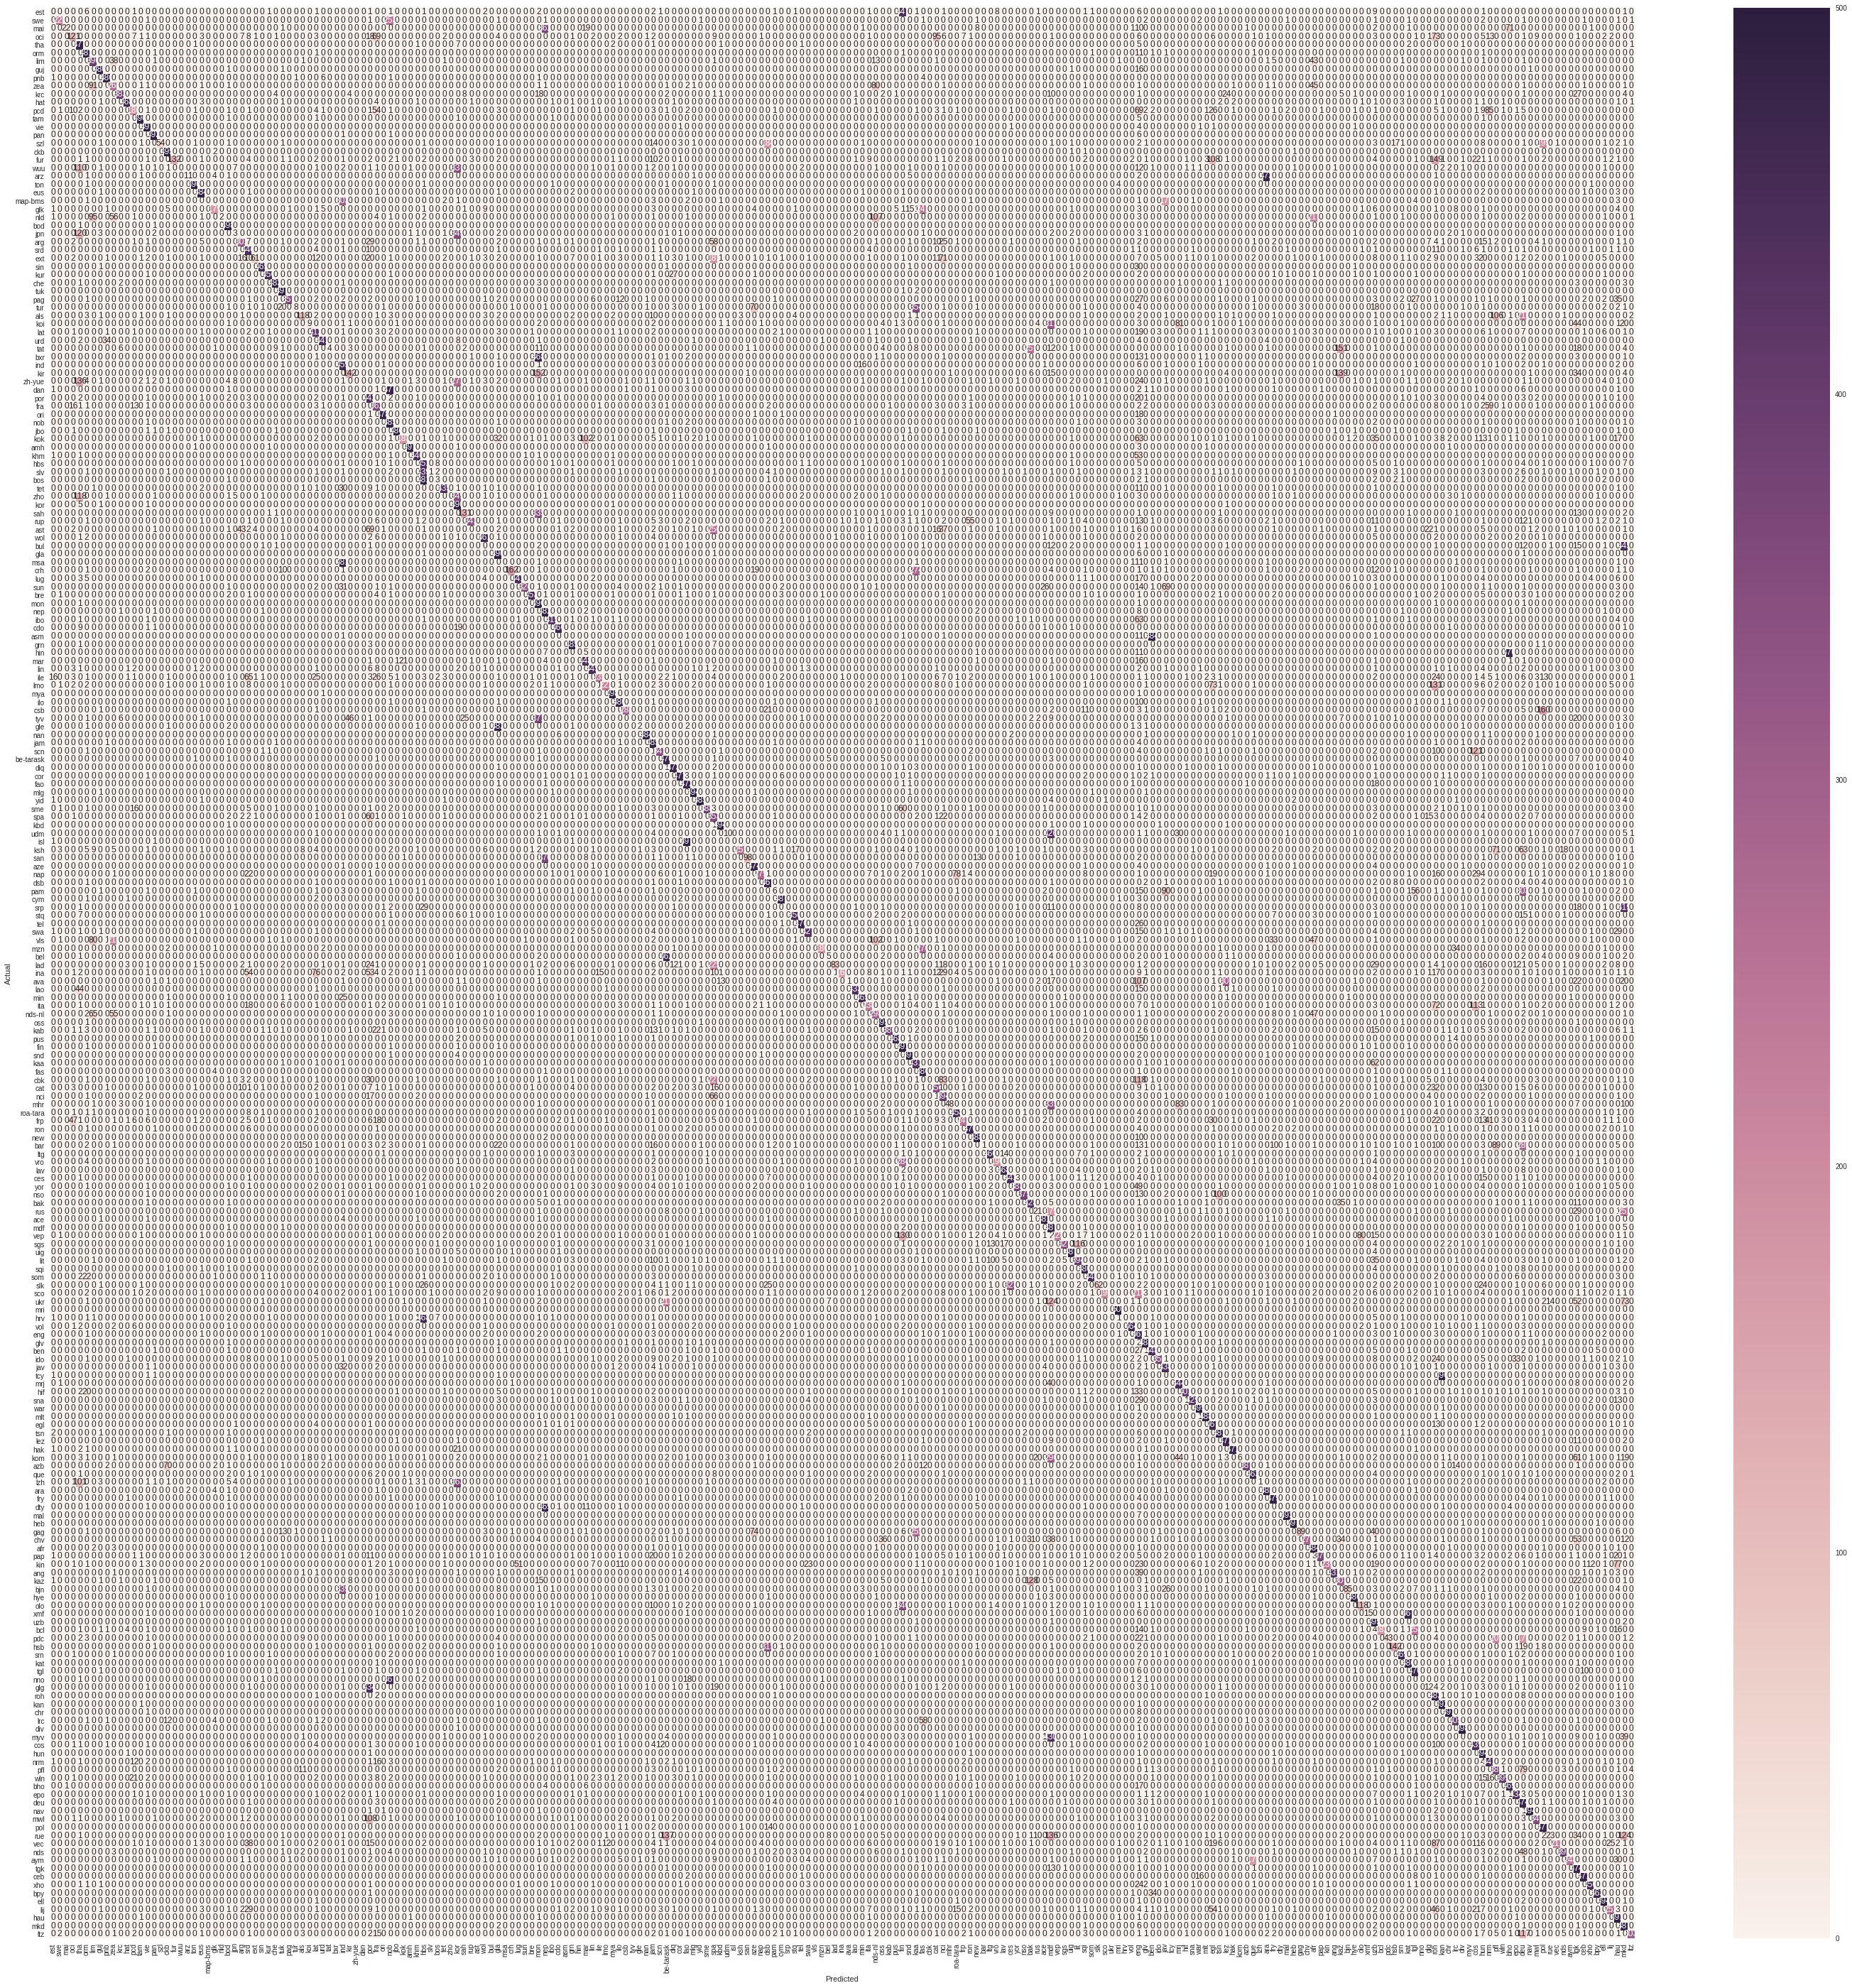

In [0]:
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_id.label.values, yticklabels=cat_id.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
# Predictions classified as English
np.sum(predictions == 'eng')

2216